<a href="https://colab.research.google.com/github/MartaP21/Cwiczenia-JS/blob/master/Copy_of_semi_supervised_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Semi-Supervised Learning**

## 🧰 1. Import bibliotek

Importujemy wszystko, co potrzebne: pandas, numpy, re do czyszczenia, modele i klastry z scikit-learn oraz matplotlib/seaborn do wykresów.

### 📖 Wytłumaczenie:
Tak jak w poprzednich ćwiczeniach – bez narzędzi nie ruszymy. Przygotowujemy warsztat do pracy.

### 💡 Ćwiczenie:
Spróbuj zaimportować dodatkowo `from sklearn.semi_supervised import SelfTrainingClassifier` – to będzie nasz główny bohater!

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 🧰 2. Stworzenie przykładowych danych

Tworzymy zbiór zgłoszeń IT oraz odpowiadające im kategorie – ale część danych będzie "nieoznaczona" (`None`).

### 📖 Wytłumaczenie:
W semi-supervised mamy część danych oznaczonych (z etykietami) i część nieoznaczonych. To odzwierciedla rzeczywistość: nie wszystkie dane są opisane!

### 💡 Ćwiczenie:
Spróbuj zmienić kilka etykiet `None` na faktyczne kategorie (np. "Sprzęt", "Sieć") i zobacz, czy model później będzie lepiej działał.

In [ ]:
texts = [
    "Problem z drukarką HP",
    "Awaria połączenia sieciowego",
    "Nie działa internet",
    "Prośba o reset hasła",
    "Zmiana ustawień konta",
    "Problem z aplikacją mobilną",
    "Reklamacja routera",
    "Brak dostępu do systemu",
    "Problem z logowaniem",
    "Aktualizacja drukarki wymaga interwencji"
]

labels = [
    "Sprzęt",
    None,
    None,
    "Konto",
    "Konto",
    "Oprogramowanie",
    "Sprzęt",
    None,
    None,
    "Sprzęt"
]

## 🧰 3. Czyszczenie tekstu

Standardowe obniżenie liter i usunięcie znaków specjalnych.

### 📖 Wytłumaczenie:
Ujednolicamy dane, żeby nie mieć zamieszania w tekstach ("drukarka" i "Drukarka" to dla maszyny coś innego!).

### 💡 Ćwiczenie:
Dodaj dodatkowy krok czyszczenia: usuń cyfry, np. `re.sub(r'\d+', '', text)`.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

texts_cleaned = [clean_text(t) for t in texts]

## 🧰 4. Przekształcenie tekstu na cechy (TF-IDF)

Zamieniamy teksty na liczby, które model będzie mógł przetwarzać.

### 📖 Wytłumaczenie:
Model nie rozumie tekstu – zamieniamy słowa na "ważności liczbowe" (TF-IDF).

### 💡 Ćwiczenie:
Dodaj własne słowo do `texts` i zobacz, czy pojawi się w macierzy TF-IDF.

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts_cleaned)

## 🧰 5. Przygotowanie etykiet

Oznaczamy nieznane etykiety jako -1 (tak tego oczekuje SelfTrainingClassifier).

### 📖 Wytłumaczenie:
Model semi-supervised musi wiedzieć, które próbki są "niewiadome".

### 💡 Ćwiczenie:
Spróbuj zmienić `None` na jakąś fałszywą kategorię i sprawdź, jak to zmienia proces.

In [ ]:
y = np.array([label if label is not None else -1 for label in labels], dtype=object)
y


array(['Sprzęt', -1, -1, 'Konto', 'Konto', 'Oprogramowanie', 'Sprzęt', -1,
       -1, 'Sprzęt'], dtype=object)

## 🧰 6. Trenowanie modelu semi-supervised

Tworzymy klasyfikator bazowy (tu Logistic Regression), potem uczymy się z pomocą Self-Training.

### 📖 Wytłumaczenie:
SelfTrainingClassifier uczy się na pewnych danych, a potem próbuje "domyślić się" etykiet niepewnych.

### 💡 Ćwiczenie:
Zmień bazowy model np. na `KNeighborsClassifier()` i zobacz, czy lepiej działa!

In [ ]:
base_model = LogisticRegression()
self_training_model = SelfTrainingClassifier(base_model)
self_training_model.fit(X, y)

SelfTrainingClassifier(estimator=LogisticRegression())

## 🧰 7. Predykcja i ocena modelu

Sprawdzamy, jak model sobie poradził z danymi (łącznie z samodzielnie przypisanymi).

### 📖 Wytłumaczenie:
Teraz widzimy, jak model "nauczył się" zgadywać brakujące etykiety.

### 💡 Ćwiczenie:
Wypisz wyniki predykcji i porównaj je z rzeczywistymi labelkami (`labels`).

In [ ]:
y_pred = self_training_model.predict(X)

print("\n=== Raport klasyfikacji ===")
print(classification_report([l if l is not None else "Nieznane" for l in labels], y_pred, zero_division=0))


=== Raport klasyfikacji ===
                precision    recall  f1-score   support

         Konto       1.00      1.00      1.00         2
      Nieznane       0.00      0.00      0.00         4
Oprogramowanie       0.00      0.00      0.00         1
        Sprzęt       0.38      1.00      0.55         3

      accuracy                           0.50        10
     macro avg       0.34      0.50      0.39        10
  weighted avg       0.31      0.50      0.36        10



## 🧰 8. Wizualizacja macierzy pomyłek

Rysujemy macierz, żeby zobaczyć, gdzie model się pomylił.

### 📖 Wytłumaczenie:
Macierz pomyłek pokazuje, jak często model trafiał, a jak często się mylił między kategoriami.

### 💡 Ćwiczenie:
Zmieniaj parametry modelu bazowego (`base_model`) i zobacz, jak zmienia się macierz.

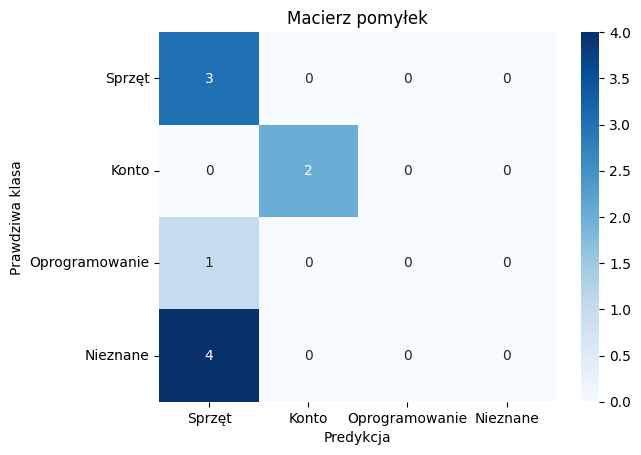

In [ ]:
cm = confusion_matrix([l if l is not None else "Nieznane" for l in labels], y_pred, labels=["Sprzęt", "Konto", "Oprogramowanie", "Nieznane"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Sprzęt", "Konto", "Oprogramowanie", "Nieznane"], yticklabels=["Sprzęt", "Konto", "Oprogramowanie", "Nieznane"])
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa klasa')
plt.title('Macierz pomyłek')
plt.show()